# The Fama-French 3 Factor Model

Expanding on the Capital Asset Pricing Model(CAPM) for stocks, the Fama-French Model is an updated version that takes size risk and value risks into account when estimating the Beta of the Stock.

Dr. Eugene Fama and Dr. Kenneth French attempted to develop a model to better understand market returns, and found that value stocks outperform growth stocks. Additionally, they found that small-cap stocks outperform large-cap stocks. They found that these factors resulted in a lower market return than the CAPM result, and could explain up to 95% of the return in a well-diversified portfolio.

The Formula is:

#### Rit ​− Rft ​= αit ​+ β1 * ​(RMt ​− Rft​) + β2 * ​SMBt ​+ β3 * ​HMLt ​+ ϵit

​Where:
- Rit​= Total Return of a Stock or Portfolio i at Time t
- Rft​= Risk-Free Rate of Return at Time t
- RMt​= Total Market Portfolio Return at Time t
- Rit​−Rft​= Expected Excess Return
- RMt​−Rft​= Excess Return on the Market Portfolio (index)
- SMBt​= Size Premium (small minus big)
- HMLt​= Value Premium (high minus low)
- β1,2,3​= Factor Coefficients​
- α = Unexplained Return
- ϵ = Random Noise

(paraphrased from Investopedia at https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp)



## Step 1: Imports and Configs

In [27]:
import pandas as pd
import yfinance as yf
import datetime as dt

The Test Portfolio is represented as a Dictionary, call symbols with stocks.keys(), call number of shares with stocks.values()

In [28]:
stocks = {
    'AMD':5,
    'AAPL': 10,
    'TM':8,
    'KO': 12,
    'SPY': 8
}

end_dt = dt.datetime.today()
start_dt = end_dt - dt.timedelta(days=(365*5))

## Step 2: Build the Dataset
### Dr. French's Data for the Model

In [29]:
ff_data_daily_path = '/Users/dB/.secret/ff-research-data/F-F_Research_Data_Factors_daily.csv'
try:
    ff_df = pd.read_csv(ff_data_daily_path, skiprows=3, index_col=0) # Read CSV, skip the intro text in the csv
    ff_df.drop(index=ff_df.index[-1], axis=0, inplace=True) # drop the "Copyright" row at the bottom
    ff_df.index = pd.to_datetime(ff_df.index, format='%Y%m%d') # Format the date column(index) into a datetime object
        
except FileNotFoundError as e:
    print(e)
    
ff_df

,Mkt-RF,SMB,HML,RF
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...
2023-11-24,0.11,0.59,0.19,0.021
2023-11-27,-0.23,-0.11,-0.08,0.021
2023-11-28,0.06,-0.29,0.05,0.021
2023-11-29,0.01,0.44,0.69,0.021


### Yahoo Finance Portfolio

In [30]:
ri_df = pd.DataFrame()

for s in stocks.keys():
    # Pull Data from yfinance
    candles_df = yf.download(tickers=s, start=start_dt, end=end_dt, interval='1d')

    # Add the Adj Close Data to a DataFrame
    adj_close_df = pd.DataFrame()
    adj_close_df[f'{s}_Adj_Close'] = candles_df['Adj Close']

    # Calculate the Return %
    adj_close_df[f'{s}_Ri'] = adj_close_df[f'{s}_Adj_Close'].resample('1D').ffill().pct_change() * 100
    adj_close_df = adj_close_df.dropna()

    ri_df[f'{s}_Ri_Pct'] = adj_close_df[f'{s}_Ri']

ri_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AMD_Ri_Pct,AAPL_Ri_Pct,TM_Ri_Pct,KO_Ri_Pct,SPY_Ri_Pct
Date,,,,,
2019-01-23,0.202424,0.404422,-0.914237,1.152552,0.209233
2019-01-24,5.303036,-0.792623,0.293950,-1.201545,0.053153
2019-01-25,5.179856,3.313688,0.724578,-0.671016,0.846142
2019-01-28,-7.979936,-0.925445,-1.002261,-0.422185,-0.760018
2019-01-29,-4.608525,-1.036473,-0.171462,0.487568,-0.132712
...,...,...,...,...,...
2024-01-12,-0.986358,0.177812,0.374453,0.969734,0.069274
2024-01-16,8.310595,-1.231709,-0.040876,-0.662358,-0.367123
2024-01-17,0.900840,-0.517351,-0.746425,0.000000,-0.555868


### Find the Weights of each Position in the Portfolio

In [31]:
tot_weight = sum(stocks.values()) # Denominator for Weight Calculation

for key in stocks:
    weight_df = pd.DataFrame()
    weight = stocks[key] / tot_weight
    ri_df[f'{key}_weight'] = weight

ri_df

,AMD_Ri_Pct,AAPL_Ri_Pct,TM_Ri_Pct,KO_Ri_Pct,SPY_Ri_Pct,AMD_weight,AAPL_weight,TM_weight,KO_weight,SPY_weight
Date,,,,,,,,,,
2019-01-23,0.202424,0.404422,-0.914237,1.152552,0.209233,0.116279,0.232558,0.186047,0.27907,0.186047
2019-01-24,5.303036,-0.792623,0.293950,-1.201545,0.053153,0.116279,0.232558,0.186047,0.27907,0.186047
2019-01-25,5.179856,3.313688,0.724578,-0.671016,0.846142,0.116279,0.232558,0.186047,0.27907,0.186047
2019-01-28,-7.979936,-0.925445,-1.002261,-0.422185,-0.760018,0.116279,0.232558,0.186047,0.27907,0.186047
2019-01-29,-4.608525,-1.036473,-0.171462,0.487568,-0.132712,0.116279,0.232558,0.186047,0.27907,0.186047
...,...,...,...,...,...,...,...,...,...,...
2024-01-12,-0.986358,0.177812,0.374453,0.969734,0.069274,0.116279,0.232558,0.186047,0.27907,0.186047
2024-01-16,8.310595,-1.231709,-0.040876,-0.662358,-0.367123,0.116279,0.232558,0.186047,0.27907,0.186047
2024-01-17,0.900840,-0.517351,-0.746425,0.000000,-0.555868,0.116279,0.232558,0.186047,0.27907,0.186047


### Calculate Weighted Average of Returns

In [32]:
wa_df = pd.DataFrame()

for s in stocks.keys():
    wa_df[f'{s}_weighted_Ri'] = ri_df[f'{s}_Ri_Pct'] * ri_df[f'{s}_weight']

wa_df['Ri_Weighted'] = wa_df.sum(axis='columns') / len(wa_df.columns)
wa_df

,AMD_weighted_Ri,AAPL_weighted_Ri,TM_weighted_Ri,KO_weighted_Ri,SPY_weighted_Ri,Ri_Weighted
Date,,,,,,
2019-01-23,0.023538,0.094052,-0.170091,0.321642,0.038927,0.061614
2019-01-24,0.616632,-0.184331,0.054688,-0.335315,0.009889,0.032313
2019-01-25,0.602309,0.770625,0.134805,-0.187260,0.157422,0.295580
2019-01-28,-0.927900,-0.215220,-0.186467,-0.117819,-0.141399,-0.317761
2019-01-29,-0.535875,-0.241040,-0.031900,0.136065,-0.024691,-0.139488
...,...,...,...,...,...,...
2024-01-12,-0.114693,0.041352,0.069666,0.270623,0.012888,0.055967
2024-01-16,0.966348,-0.286444,-0.007605,-0.184844,-0.068302,0.083831
2024-01-17,0.104749,-0.120314,-0.138870,0.000000,-0.103417,-0.051570


### Combine the DataFrames

In [34]:
model_df = pd.concat([wa_df['Ri_Weighted'], ff_df], axis=1)
model_df = model_df.dropna()

model_df

,Ri_Weighted,Mkt-RF,SMB,HML,RF
2019-01-23,0.061614,0.15,-0.39,-0.13,0.010
2019-01-24,0.032313,0.23,0.44,-0.01,0.010
2019-01-25,0.295580,0.90,0.46,-0.35,0.010
2019-01-28,-0.317761,-0.80,-0.16,0.63,0.010
2019-01-29,-0.139488,-0.19,-0.01,0.17,0.010
...,...,...,...,...,...
2023-11-24,0.062449,0.11,0.59,0.19,0.021
2023-11-27,-0.048522,-0.23,-0.11,-0.08,0.021
2023-11-28,0.028922,0.06,-0.29,0.05,0.021
2023-11-29,0.020666,0.01,0.44,0.69,0.021


## Step 3: Run Regression

#### Equation:

##### Rit ​− Rft ​= αit ​+ β1 * ​(RMt ​− Rft​) + β2 * ​SMBt ​+ β3 * ​HMLt ​+ ϵit

### Defining the Variables

In [38]:
# Calculating Rit - Rft
model_df['Ri-RF'] = model_df['Ri_Weighted'] - model_df['RF']

# Independent Variables
iv = model_df[['Mkt-RF','SMB','HML']]

# Dependent Variable
dv = model_df['Ri-RF']

### Build Regression Model with Statsmodel.API

In [39]:
import statsmodels.api as sm

ic = sm.add_constant(iv)

model = sm.OLS(dv, ic)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Ri-RF   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     2789.
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:22:46   Log-Likelihood:                 1103.0
No. Observations:                1224   AIC:                            -2198.
Df Residuals:                    1220   BIC:                            -2177.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.416      0.677      -0.004       0.007
Mkt-RF         0.1888      0.002     90.372      0.000       0.185       0.193
SMB           -0.0436      0.004    -10.979      0.000      -0.051      -0.036
HML           -0.0138      0.002     -5.566      0.000      -0.019      -0.009
==============================================================================
Omnibus:                      114.850   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              312.673
Skew:                           0.498   Prob(JB):                     1.27e-68
Kurtosis:                       5.267   Cond. No.                         2.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 4: Analyzing the Outputs

### From the Table(run on 1/20/24): 

##### α: 0.0012 ('const' row; 'coef' column)

##### β1: 0.1888 ('Mkt-RF' row; 'coef' column)

##### β2: -0.0436 ('SMB' row; 'coef' column)

##### β3: -0.0138 ('HML' row; 'coef' column)

### Takeaways:

- The Portfolio's Beta is .1888, which means the portfolio moves up .1888% for every 1% that the total market moves up, which is very poor performance.
- All of the Coefficients seem very small, however I don't have a great frame of reference for if these results feel realistic. I will need to talk to my professors and see if this is realistic or if my model is incorrect

## Plotting the Regression

<Axes: xlabel='Mkt-RF', ylabel='Ri_Weighted'>

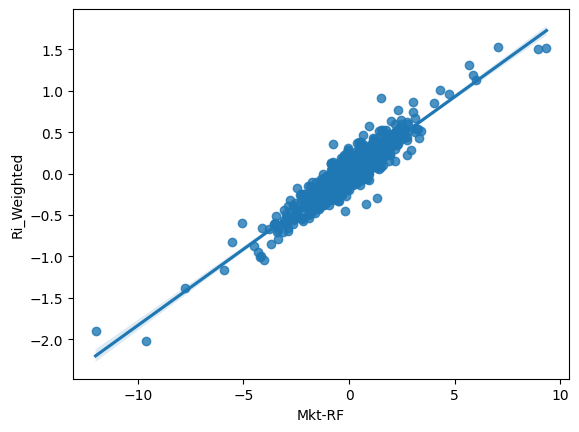

In [41]:
import seaborn as sns
sns.regplot(x='Mkt-RF', y='Ri_Weighted', data=model_df)

### Takeaways:
- I will definitely revisit this topic after speaking with my professors and doing some more research on the theory behind the Fama-French Model, but this was good practice.
- Check to see if using the Weighted Average of Ri is correct, or if I should just sum the Ri's of each stock